In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir  = "/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset"

In [4]:
data_list = glob.glob(os.path.join(data_dir, '**.csv'))
data_list

['/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/x_train.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/x_test.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/submission_csv_file_random_example.csv',
 '/content/drive/MyDrive/U4_Prediction_stock_auction_volumes/dataset/y_train.csv']

In [5]:
id_col = 'ID'
target_col = "target"

In [6]:
y_train = pd.read_csv("%s/y_train.csv" % data_dir, sep=",")
x_train = pd.read_csv("%s/x_train.csv" % data_dir, sep=",")
x_test=pd.read_csv("%s/x_test.csv" % data_dir, sep=",")

In [7]:
train_df  = y_train.merge(x_train, on="ID")

In [8]:
train_df.head()

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
0,148,-3.403606,360,0,0.000000,0.000000,0.0,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.0,0.036601,0.102399,0.029261,0.00000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.0,0.036630,0.007326,0.000000,0.0,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.0,0.021989,...,0.019147,0.023043,0.010204,0.015254,0.006455,0.006221,0.007477,0.015452,0.005510,0.014621,0.004915,0.009695,0.014404,0.011438,0.005018,0.003520,0.006112,0.001629,0.007395,0.007272,0.017971,0.007965,0.003240,0.008937,0.008786,0.009677,0.008480,0.011040,0.004054,0.009431,0.004521,0.015771,0.009462,0.012697,0.019507,0.005101,0.010654,0.006971,-2.307230,0.646580
1,149,-2.904798,360,1,0.000000,0.000000,0.0,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.0,0.014700,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.0,0.000000,...,0.007153,0.010241,0.005084,0.010341,0.009629,0.008034,0.012606,0.022932,0.002855,0.010928,0.004953,0.001122,0.007357,0.032969,0.004212,0.004200,0.002189,0.004183,0.000931,0.000753,0.008522,0.011424,0.042281,0.003987,0.002132,0.003802,0.003952,0.009427,0.017466,0.023188,0.008817,0.006589,0.005276,0.011648,0.011829,0.015558,0.001788,0.005251,-2.263960,0.487708
2,150,-2.337807,360,2,0.000000,0.000000,0.0,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,NaN,0.000000,0.051902,0.000000,0.02227,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.0,0.022166,0.000000,0.000000,0.0,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.008215,0.015199,0.007220,0.007814,0.003919,0.012528,0.005863,0.008573,0.009908,0.004453,0.007961,0.003208,0.006635,0.002473,0.001524,0.007806,0.002231,0.006975,0.004943,0.002252,0.007676,0.022513,0.124384,0.017086,0.023940,0.036648,0.025713,0.020880,0.009542,0.006752,0.018640,0.020972,0.012728,0.007921,0.000643,0.029692,0.016440,0.011970,-2.343106,0.544476
3,151,-2.285676,360,3,0.000000,0.007384,0.0,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.0,0.000000,0.000000,0.007423,0.00000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.0,0.000000,0.000000,0.007389,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.0,0.000000,...,0.003782,0.029602,0.013475,0.031606,0.007952,0.021086,0.010731,0.025026,0.004192,0.009762,0.016240,0.012835,0.008973,0.023312,0.003007,0.009878,0.011719,0.009139,0.006265,0.010273,0.012355,0.011745,0.001635,0.005562,0.007811,0.010685,0.062768,0.072686,0.009503,0.017088,0.013628,0.020397,0.016834,0.031869,0.012468,0.065173,0.048286,0.021237,-2.331621,0.633181
4,152,-2.606321,360,4,0.088086,0.109737,0.0,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.0,0.000000,0.050850,0.000000,0.00000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.0,0.000000,0.000000,0.000000,0.0,0.076542,0.182548,0.000000,0.051136,0.007305,0.000000,0.000000,0.0,0.051230,...,0.008732,0.009927,0.006543,0.043907,0.015489,0.039439,0.027264,0.024433,0.008796,0.002315,0.005078,0.005520,0.015532,0.031905,0.005469,0.015763,0.005532,0.014603,0.018986,0.006

In [9]:
return_cols = [c for c in train_df.columns if c.startswith("abs_ret")]
volume_cols = [c for c in train_df.columns if c.startswith("rel_vol")]
date_col = ["day"]
prod_id_col=["pid"]
other_cols = ["LS" , "NLV"]

In [10]:
train_df.describe()

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
count,6.844820e+05,684482.000000,684482.000000,684482.000000,679486.000000,656703.000000,657590.000000,662537.000000,660968.000000,657137.000000,664679.000000,662713.000000,660873.000000,660250.000000,660582.000000,659018.000000,663139.000000,661327.000000,661253.000000,657104.000000,657800.000000,657010.000000,660496.000000,658816.000000,657421.000000,655940.000000,657361.000000,656934.000000,656315.000000,653150.000000,652227.000000,649753.000000,652781.000000,651373.000000,651654.000000,649756.000000,647184.000000,646107.000000,647701.000000,645523.000000,...,6.569340e+05,656315.000000,653150.000000,6.522270e+05,6.497530e+05,6.527810e+05,6.513730e+05,6.516540e+05,6.497560e+05,6.471840e+05,646107.000000,6.477010e+05,645523.000000,6.475250e+05,645294.000000,6.462170e+05,6.447980e+05,6.475500e+05,646127.000000,6.446600e+05,643984.000000,642983.000000,641625.000000,645905.000000,6.436030e+05,645635.000000,6.463020e+05,6.459970e+05,645877.000000,6.478460e+05,6.489580e+05,653719.000000,6.538930e+05,652452.000000,6.526000e+05,6.530030e+05,6.539240e+05,6.545230e+05,684482.000000,684482.000000
mean,6.862229e+05,-1.958691,449.451723,412.493759,0.397610,0.329012,0.255827,0.229207,0.204163,0.187032,0.188361,0.169918,0.162275,0.155261,0.148724,0.143293,0.151249,0.140538,0.136103,0.129922,0.128359,0.125361,0.127493,0.120510,0.119549,0.118403,0.115798,0.116196,0.114916,0.110808,0.107223,0.105218,0.104255,0.102661,0.102158,0.097533,0.095072,0.096269,0.094578,0.090031,...,1.725734e-02,0.017128,0.015789,1.531270e-02,1.508535e-02,1.507723e-02,1.477901e-02,1.501575e-02,1.429591e-02,1.355691e-02,0.013769,1.371360e-02,0.013169,1.338470e-02,0.013222,1.313102e-02,1.307143e-02,1.333968e-02,0.013568,1.386745e-02,0.013391,0.013005,0.013023,0.013509,1.317827e-02,0.013808,1.375484e-02,1.361034e-02,0.013826,1.414312e-02,1.434824e-02,0.016687,1.608437e-02,0.015683,1.590250e-02,1.580415e-02,1.618791e-02,1.679593e-02,-3.185075,-0.018128
std,4.166922e+05,0.909245,260.605228,231.328674,0.545231,0.420742,0.334599,0.292831,0.261129,0.240466,0.234162,0.212652,0.203756,0.193350,0.185754,0.181478,0.193961,0.179048,0.170288,0.164229,0.164041,0.158586,0.160930,0.151733,0.151839,0.151854,0.149530,0.146434,0.145757,0.143107,0.139733,0.136572,0.135772,0.133423,0.135164,0.127663,0.125301,0.127174,0.124235,0.121804,...,1.595654e-02,0.015979,0.014941,1.459300e-02,1.453749e-02,1.449819e-02,1.439389e-02,1.428812e-02,1.399669e-02,1.388352e-02,0.013795,1.381327e-02,0.013395,1.360584e-02,0.013584,1.347923e-02,1.349071e-02,1.412337e-02,0.017034,1.403228e-02,0.013532,0.013292,0.013264,0.013466,1.322680e-02,0.013556,1.351436e-02,1.367238e-02,0.013744,1.386390e-02,1.391984e-02,0.015841,1.481085e-02,0.014791,1.488205e-02,1.491830e-02,1.495403e-02,1.551244e-02,1.072115,1.002738
min,1.480000e+02,-7.137686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.260560e-07,0.000001,0.000001,9.406181e-07,4.631040e-07,4.738354e-07,7.686187e-07,6.755771e-0

In [11]:
x_test

,ID,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
0,1070752,360,805,0.318973,0.000000,0.036477,0.060808,0.121546,0.036420,0.020217,0.092986,0.238201,0.092619,0.108530,0.128468,0.200353,0.004015,0.148559,0.322035,0.160533,0.136700,0.100575,0.056379,0.000000,0.100620,0.052257,0.160862,0.004017,0.136788,0.028121,0.020098,0.060292,0.140856,0.052272,0.000000,0.020108,0.020116,0.024142,0.056318,0.048296,...,0.009163,0.007675,0.018202,0.019195,0.015574,0.015371,0.008336,0.013979,0.008263,0.004117,0.016569,0.011553,0.008768,0.017383,0.005807,0.006806,0.010702,0.004581,0.005828,0.025984,0.005955,0.015144,0.018400,0.006715,0.003392,0.003688,0.003096,0.004943,0.011420,0.016239,0.005421,0.010815,0.008139,0.012176,0.014125,0.007319,0.010002,0.009969,-1.443817,0.666302
1,1070753,360,806,0.088113,0.076165,0.016047,0.224548,0.148030,0.004007,0.012021,0.092159,0.072092,0.076043,0.008011,0.076094,0.040037,0.052069,0.056045,0.084114,0.096050,0.012018,0.016022,0.004005,0.056040,0.020003,0.027999,0.048021,0.008000,0.047994,0.032000,0.036019,0.000000,0.032047,0.088130,0.056034,0.016019,0.040053,0.012011,0.012010,0.028026,...,0.014351,0.017198,0.003015,0.023345,0.012634,0.001478,0.009961,0.024508,0.018175,0.005994,0.003361,0.012839,0.009429,0.001506,0.002605,0.013738,0.002173,0.004291,0.036430,0.047426,0.013830,0.023777,0.011122,0.000884,0.017628,0.027335,0.011698,0.014778,0.004191,0.020049,0.003653,0.027143,0.030775,0.012852,0.010340,0.013970,0.015756,0.015426,-1.733723,0.691423
2,1070754,360,807,0.215629,0.095538,0.211088,0.071851,0.229358,0.262660,0.279140,0.047731,0.015903,0.131213,0.099554,0.083499,0.039760,0.019872,0.007944,0.023831,0.099273,0.031799,0.031789,0.000000,0.000000,0.065544,0.132987,0.027826,0.011929,0.027831,0.111248,0.103211,0.003974,0.079504,0.019860,0.015883,0.039714,0.063507,0.055542,0.000000,0.011895,...,0.013877,0.011801,0.006512,0.009160,0.012597,0.002149,0.018688,0.025565,0.020523,0.016583,0.013561,0.016600,0.000372,0.012172,0.023141,0.007881,0.007734,0.019982,0.010477,0.003577,0.011061,0.064398,0.004371,0.027042,0.028628,0.009537,0.006730,0.012251,0.018463,0.018347,0.015072,0.007164,0.012834,0.005153,0.016616,0.031887,0.000413,0.025075,-1.595646,0.708518
3,1070755,360,808,0.000000,0.498306,0.031819,0.027795,0.023813,0.099198,0.067608,0.011939,0.159204,0.223383,0.073963,0.104062,0.043917,0.007988,0.191785,0.096061,0.075976,0.035954,0.075930,0.131779,0.031892,0.135550,0.115773,0.004000,0.099980,0.039952,0.031949,0.083893,0.023979,0.015990,0.027998,0.036017,0.020031,0.016022,0.100088,0.071983,0.076043,...,0.028497,0.018524,0.010778,0.005553,0.005624,0.031128,0.007775,0.011587,0.028091,0.011324,0.035279,0.015468,0.011935,0.012825,0.013162,0.002072,0.002675,0.016534,0.017281,0.032332,0.018875,0.008087,0.030003,0.016106,0.013949,0.013638,0.016452,0.010951,0.018499,0.023242,0.013314,0.020483,0.016145,0.010154,0.035758,0.013969,0.020954,0.028234,-1.495998,0.674784
4,1070756,360,809,0.052521,0.064607,0.036336,0.121153,0.108871,0.302749,0.189150,0.209087,0.132989,0.072438,0.148947,0.164745,0.092589,0.088485,0.056259,0.128726,0.153028,0.020164,0.052415,0.052428,0.084633,0.084691,0.080557,0.092716,0.120822,0.052293,0.036222,0.008048,0.044269,0.012068,0.108626,0.024182,0.024181,0.016117,0.028209,0.032229,0.028196,...,0.011878,0.010243,

In [12]:
# Let's analyze stock number 1
stock_1 = train_df.loc[train_df['pid'] == 1]
stock_1

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
73368,145244,-2.122217,1,0,0.037272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.075038,0.075000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,...,0.002679,NaN,0.000054,0.000161,NaN,0.008442,0.043169,0.024430,0.010725,0.005363,0.032688,NaN,0.005359,0.002680,0.013693,0.002706,0.000161,NaN,0.000402,0.007904,0.008038,0.002729,0.013861,0.012056,0.000107,0.018766,0.005354,0.002730,0.000134,0.002518,0.005387,0.005473,0.021898,0.050932,0.005442,0.040114,0.021456,0.005418,-1.986009,-0.851069
73369,145245,-0.483335,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024719,0.000000,0.000000,0.000000,0.074129,0.000000,0.000000,0.000000,0.061835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000036,0.023875,0.016635,0.004781,0.003577,0.034492,0.008025,0.003551,0.010627,0.015373,0.017742,0.033858,0.027508,0.051185,0.000307,0.003606,0.017412,0.017890,0.013173,0.016976,0.012953,0.007102,0.007172,0.002434,0.004857,0.028133,0.000401,0.007122,0.006280,0.005500,0.018922,0.015108,0.002526,0.004898,0.022815,0.057084,0.003873,0.016391,-1.801845,-0.337335
73370,145246,-3.097364,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.012455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024759,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,...,0.007666,0.009315,0.007335,0.005501,0.005758,0.003667,0.008050,0.001834,0.001834,0.010905,NaN,NaN,0.012073,0.022853,NaN,0.007684,0.004947,NaN,0.171622,0.014673,0.068003,0.033601,0.006970,0.005722,0.024040,0.010995,0.034862,0.001835,0.010745,NaN,0.044686,0.010542,0.039723,0.013378,0.003670,0.013264,0.002202,0.002148,-1.759012,-0.610176
73371,145247,-2.714733,1,3,0.357187,0.000000,0.012323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049273,0.000000,0.000000,0.000000,0.000000,0.117082,0.000000,0.024519,0.000000,0.000000,0.012237,0.000000,...,0.012775,0.020546,0.080257,0.016429,0.012888,0.010955,0.108702,0.134175,0.024590,0.023166,0.018106,0.014128,0.022354,0.048091,0.041600,0.030264,0.014754,0.001832,0.000916,0.002199,0.003820,0.001869,0.002951,0.000009,0.000027,0.007119,0.001832,0.000962,0.000027,0.017056,0.006609,0.004383,0.005728,0.002219,0.006436,0.011048,0.009123,0.019401,-1.615954,-0.172240
73372,145248,-1.802809,1,4,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048614,0.000000,NaN,0.000000,0.024393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073037,0.000000,0.000000,0.012180,NaN,0.000000,0.000000,0.000000,0.000000,0.048745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.059666,NaN,0.018215,0.024419,0.021450,0.011546,0.023106,0.013222,0.014860,0.003300,0.003300,0.013484,0.014775,0.023183,0

In [13]:
stock_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 73368 to 629517
Columns: 128 entries, ID to NLV
dtypes: float64(125), int64(3)
memory usage: 808.3 KB


In [14]:
#stock_1.loc[:, 'day'] = pd.to_datetime(stock_1.loc[:,'day'], format="%Y/%m/%d")

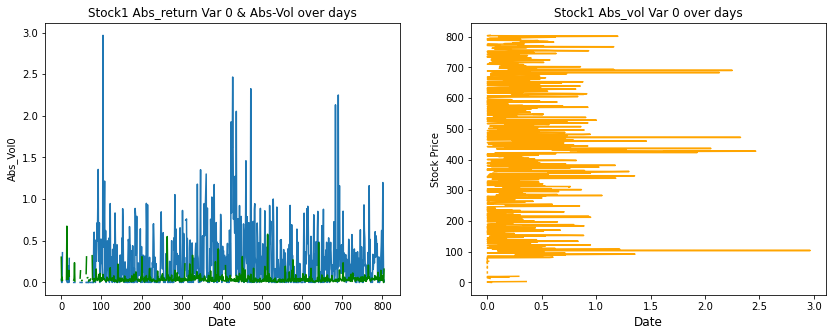

In [15]:
# Simple plotting of Stock1
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(stock_1["day"], stock_1["abs_ret0"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Abs_ret")
ax1.set_title("Stock1 Abs_return Var 0 & Abs-Vol over days")
# Second Subplot
ax1.plot(stock_1["day"], stock_1["rel_vol0"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Abs_Vol0")
ax1.set_title("Stock1 Abs_return Var 0 & Abs-Vol over days")

# Fourth Subplot
ax2.plot(stock_1["abs_ret0"], stock_1["day"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Stock1 Abs_vol Var 0 over days")
plt.show()


Var during one day of return & Vol

2 sol : index with time vector or long format

In [16]:
l = [i for i in range(60)]

In [17]:
# Let's analyze stock number 1
stock_1_day1 = stock_1.loc[stock_1['day'] == 0]
stock_1_day1

,ID,target,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
73368,145244,-2.122217,1,0,0.037272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.075038,0.075,0.0,0.0,0.0,0.0,NaN,0.0,...,0.002679,NaN,0.000054,0.000161,NaN,0.008442,0.043169,0.02443,0.010725,0.005363,0.032688,NaN,0.005359,0.00268,0.013693,0.002706,0.000161,NaN,0.000402,0.007904,0.008038,0.002729,0.013861,0.012056,0.000107,0.018766,0.005354,0.00273,0.000134,0.002518,0.005387,0.005473,0.021898,0.050932,0.005442,0.040114,0.021456,0.005418,-1.986009,-0.851069


In [18]:
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
#ax1.plot(l, stock_1["abs_ret0"])
#ax1.set_xlabel("Date", fontsize=12)
#ax1.set_ylabel("Abs_ret")
#ax1.set_title("Stock1 Abs_return Var 0 & Abs-Vol over days")

Quick strating kit

In [19]:
train_df.isnull().sum(axis=1)

0         0
1         0
2         2
3         0
4         0
         ..
684477    8
684478    4
684479    6
684480    2
684481    0
Length: 684482, dtype: int64

In [20]:
x_test.isnull().sum(axis=1)

0          0
1          0
2          0
3          0
4          0
          ..
311739     0
311740    38
311741     0
311742     0
311743     2
Length: 311744, dtype: int64

Interpoloate nan

In [21]:
#x_train.iloc[:,3:] = x_train.iloc[:,3:].interpolate(axis=1)
#x_test.iloc[:,3:]  = x_test.iloc[:,3:].interpolate(axis=1)

In [22]:
x_test.isnull().sum(axis=1)

0          0
1          0
2          0
3          0
4          0
          ..
311739     0
311740    38
311741     0
311742     0
311743     2
Length: 311744, dtype: int64

In [23]:
np.any(np.isnan(x_train))

True

In [24]:
np.all(np.isfinite(x_train))

False

In [25]:
x_train.fillna(0, inplace=True) 
x_test.fillna(0, inplace=True)

## Feature engineering

Create basic feature

In [26]:
x_train['min_ret']    = np.min(x_train.iloc[:,3:63], axis=1)
x_train['max_ret']    = np.max(x_train.iloc[:,3:63], axis=1)
x_train['std_ret']    = np.std(x_train.iloc[:,3:63], axis=1)
x_train['median_ret'] = np.median(x_train.iloc[:,3:63], axis=1)

In [27]:
x_test['min_ret']    = np.min(x_test.iloc[:,3:63], axis=1)
x_test['max_ret']    = np.max(x_test.iloc[:,3:63], axis=1)
x_test['std_ret']    = np.std(x_test.iloc[:,3:63], axis=1)
x_test['median_ret'] = np.median(x_test.iloc[:,3:63], axis=1)

In [28]:
x_train['min_vol']    = np.min(x_train.iloc[:,64:125], axis=1)
x_train['max_vol']    = np.max(x_train.iloc[:,64:125], axis=1)
x_train['std_vol']    = np.std(x_train.iloc[:,64:125], axis=1)
x_train['median_vol'] = np.median(x_train.iloc[:,64:125], axis=1)

In [29]:
x_test['min_vol']    = np.min(x_test.iloc[:,64:125], axis=1)
x_test['max_vol']    = np.max(x_test.iloc[:,64:125], axis=1)
x_test['std_vol']    = np.std(x_test.iloc[:,64:125], axis=1)
x_test['median_vol'] = np.median(x_test.iloc[:,64:125], axis=1)

Validation

In [30]:
def Error(y_true, y_pred): 
    return np.square(y_true - y_pred)

In [31]:
def MSE(y_true, y_pred): 
    return np.square(y_true - y_pred)

In [32]:
from sklearn.model_selection import train_test_split

train_df  = y_train.merge(x_train, on="ID")
train_df.drop(['ID', 'pid'], axis=1, inplace=True)

train_X_, test_X_, train_y_, test_y_ = train_test_split(train_df.iloc[:,1:], train_df['target'], test_size=0.2, random_state=42)

In [33]:
#pip install delayed

In [34]:
import delayed

In [35]:
from sklearn.linear_model import LinearRegression

regrLinWeighted = LinearRegression()
regrLinWeighted.fit(train_X_, train_y_)

LinearRegression()

In [36]:
test_X_['predict'] = regrLinWeighted.predict(test_X_)

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
(mean_squared_error(test_y_, test_X_['predict']))

0.6239513625421437

In [39]:
test_y_=pd.DataFrame(test_y_)

In [40]:
test_X_['error']=test_y_["target"] - test_X_['predict']

In [41]:
test_X_

,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,abs_ret38,...,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV,min_ret,max_ret,std_ret,median_ret,min_vol,max_vol,std_vol,median_vol,predict,error
99589,41,0.000000,0.000000,0.327869,0.000000,0.000000,0.000000,0.000000,0.072464,0.018067,0.036114,0.000000,0.000000,0.000000,0.323625,0.018060,0.000000,0.000000,0.036101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071891,0.000000,0.000000,...,0.009277,0.018154,0.007362,0.044222,0.010593,0.009420,0.005716,0.008562,0.095894,0.004931,0.005191,0.006736,0.007368,0.014367,0.029503,0.002459,0.007550,0.000000,0.002459,0.004949,0.002456,0.029123,0.004928,0.002464,0.002468,0.000518,0.002832,0.012310,-2.903046,-1.453430,0.0,0.327869,0.061653,0.000000,0.000000,0.095894,0.020351,0.007550,-1.859037,0.498510
535740,587,0.479781,0.205128,0.000000,0.306748,0.119760,0.034165,0.136565,0.034072,0.068236,0.000000,0.102284,0.375299,0.101902,0.068027,0.051003,0.034002,0.102041,0.068074,0.102041,0.169895,0.204082,0.101695,0.000000,0.169722,0.101557,0.033887,0.067843,0.033898,0.033887,0.338753,0.101971,0.102076,0.000000,0.068050,0.102145,0.102284,0.034072,0.136333,0.238338,...,0.016219,0.015041,0.020853,0.015026,0.013870,0.016534,0.009130,0.010625,0.020234,0.005510,0.012462,0.006104,0.029522,0.010263,0.011031,0.008948,0.013158,0.026983,0.010673,0.019144,0.009577,0.017023,0.016518,0.023059,0.022616,0.026753,0.022046,0.014671,-3.811589,-0.430984,0.0,0.479781,0.094186,0.068143,0.005014,0.030123,0.006028,0.015041,-1.276157,0.196941
228479,230,0.709849,0.719741,0.590842,0.000000,0.587027,0.118099,0.118343,0.029595,0.265487,0.029420,0.117716,0.000000,0.442087,0.266825,0.059542,0.297530,0.148324,0.147885,0.207162,0.059347,0.088968,0.029665,0.088994,0.029674,0.029638,0.088994,0.029709,0.148677,0.119190,0.178625,0.178306,0.178571,0.178731,0.059453,0.089153,0.000000,0.029691,0.118730,0.089153,...,0.010738,0.015354,0.008038,0.023330,0.023412,0.011349,0.011978,0.006291,0.001232,0.012476,0.006339,0.016919,0.013850,0.024074,0.010804,0.008154,0.008557,0.016805,0.011478,0.005863,0.001066,0.011584,0.006165,0.023516,0.025864,0.018345,0.027006,0.014161,-3.318202,-0.133514,0.0,0.719741,0.162341,0.089339,0.001066,0.070583,0.010798,0.013650,-1.999648,-0.336535
214338,396,0.606290,0.151573,0.037836,0.113550,0.037893,0.151400,0.113723,0.113636,0.304183,0.037908,0.075758,0.075815,0.075758,0.037979,0.076017,0.000000,0.037979,0.114025,0.265756,0.037864,0.000000,0.075930,0.000000,0.037994,0.113938,0.190114,0.113852,0.000000,0.151976,0.303030,0.266261,0.075758,0.037994,0.038008,0.076046,0.190259,0.379795,0.113507,0.000000,...,0.011290,0.028666,0.008297,0.011444,0.022618,0.003237,0.014889,0.005080,0.010819,0.011934,0.014852,0.011184,0.008185,0.017893,0.016515,0.019558,0.009751,0.001625,0.010413,0.034057,0.013161,0.006567,0.007358,0.007497,0.001623,0.015991,0.008228,0.000000,-3.148261,-1.226465,0.0,0.606290,0.116823,0.075873,0.000000,0.059053,0.013184,0.012316,-1.750885,1.911004
242520,302,0.680760,0.036088,0.144456,0.108186,0.036023,0.072072,0.000000,0.216216,0.251527,0.215054,0.000000,0.107720,0.071891,0.107759,0.143524,0.000000,0.107450,0.196745,0.107066,0.071480,0.143062,0.000000,0.017857,0.053581,0.000000,0.178699,0.071352,0.142552,0.071174,0.106838,0.178253,0.000000,0.035587,0.106800,0.160399,0.177936,0.035524,0

In [42]:
test_X_.iloc[:,0:134]

,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,abs_ret38,...,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV,min_ret,max_ret,std_ret,median_ret,min_vol,max_vol,std_vol,median_vol,predict
99589,41,0.000000,0.000000,0.327869,0.000000,0.000000,0.000000,0.000000,0.072464,0.018067,0.036114,0.000000,0.000000,0.000000,0.323625,0.018060,0.000000,0.000000,0.036101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071891,0.000000,0.000000,...,0.007349,0.009277,0.018154,0.007362,0.044222,0.010593,0.009420,0.005716,0.008562,0.095894,0.004931,0.005191,0.006736,0.007368,0.014367,0.029503,0.002459,0.007550,0.000000,0.002459,0.004949,0.002456,0.029123,0.004928,0.002464,0.002468,0.000518,0.002832,0.012310,-2.903046,-1.453430,0.0,0.327869,0.061653,0.000000,0.000000,0.095894,0.020351,0.007550,-1.859037
535740,587,0.479781,0.205128,0.000000,0.306748,0.119760,0.034165,0.136565,0.034072,0.068236,0.000000,0.102284,0.375299,0.101902,0.068027,0.051003,0.034002,0.102041,0.068074,0.102041,0.169895,0.204082,0.101695,0.000000,0.169722,0.101557,0.033887,0.067843,0.033898,0.033887,0.338753,0.101971,0.102076,0.000000,0.068050,0.102145,0.102284,0.034072,0.136333,0.238338,...,0.019960,0.016219,0.015041,0.020853,0.015026,0.013870,0.016534,0.009130,0.010625,0.020234,0.005510,0.012462,0.006104,0.029522,0.010263,0.011031,0.008948,0.013158,0.026983,0.010673,0.019144,0.009577,0.017023,0.016518,0.023059,0.022616,0.026753,0.022046,0.014671,-3.811589,-0.430984,0.0,0.479781,0.094186,0.068143,0.005014,0.030123,0.006028,0.015041,-1.276157
228479,230,0.709849,0.719741,0.590842,0.000000,0.587027,0.118099,0.118343,0.029595,0.265487,0.029420,0.117716,0.000000,0.442087,0.266825,0.059542,0.297530,0.148324,0.147885,0.207162,0.059347,0.088968,0.029665,0.088994,0.029674,0.029638,0.088994,0.029709,0.148677,0.119190,0.178625,0.178306,0.178571,0.178731,0.059453,0.089153,0.000000,0.029691,0.118730,0.089153,...,0.012670,0.010738,0.015354,0.008038,0.023330,0.023412,0.011349,0.011978,0.006291,0.001232,0.012476,0.006339,0.016919,0.013850,0.024074,0.010804,0.008154,0.008557,0.016805,0.011478,0.005863,0.001066,0.011584,0.006165,0.023516,0.025864,0.018345,0.027006,0.014161,-3.318202,-0.133514,0.0,0.719741,0.162341,0.089339,0.001066,0.070583,0.010798,0.013650,-1.999648
214338,396,0.606290,0.151573,0.037836,0.113550,0.037893,0.151400,0.113723,0.113636,0.304183,0.037908,0.075758,0.075815,0.075758,0.037979,0.076017,0.000000,0.037979,0.114025,0.265756,0.037864,0.000000,0.075930,0.000000,0.037994,0.113938,0.190114,0.113852,0.000000,0.151976,0.303030,0.266261,0.075758,0.037994,0.038008,0.076046,0.190259,0.379795,0.113507,0.000000,...,0.059053,0.011290,0.028666,0.008297,0.011444,0.022618,0.003237,0.014889,0.005080,0.010819,0.011934,0.014852,0.011184,0.008185,0.017893,0.016515,0.019558,0.009751,0.001625,0.010413,0.034057,0.013161,0.006567,0.007358,0.007497,0.001623,0.015991,0.008228,0.000000,-3.148261,-1.226465,0.0,0.606290,0.116823,0.075873,0.000000,0.059053,0.013184,0.012316,-1.750885
242520,302,0.680760,0.036088,0.144456,0.108186,0.036023,0.072072,0.000000,0.216216,0.251527,0.215054,0.000000,0.107720,0.071891,0.107759,0.143524,0.000000,0.107450,0.196745,0.107066,0.071480,0.143062,0.000000,0.017857,0.053581,0.000000,0.178699,0.071352,0.142552,0.071174,0.106838,0.178253,0.000000,0.035587,0.106800,0.160399,0.177936,0.03552

In [43]:
test_X_reset = test_X_.copy()

In [44]:
test_X_reset.reset_index(drop=True, inplace=True)
test_X_reset

,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,abs_ret38,...,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV,min_ret,max_ret,std_ret,median_ret,min_vol,max_vol,std_vol,median_vol,predict,error
0,41,0.000000,0.000000,0.327869,0.000000,0.000000,0.000000,0.000000,0.072464,0.018067,0.036114,0.000000,0.000000,0.000000,0.323625,0.018060,0.000000,0.000000,0.036101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071891,0.000000,0.000000,...,0.009277,0.018154,0.007362,0.044222,0.010593,0.009420,0.005716,0.008562,0.095894,0.004931,0.005191,0.006736,0.007368,0.014367,0.029503,0.002459,0.007550,0.000000,0.002459,0.004949,0.002456,0.029123,0.004928,0.002464,0.002468,0.000518,0.002832,0.012310,-2.903046,-1.453430,0.0,0.327869,0.061653,0.000000,0.000000,0.095894,0.020351,0.007550,-1.859037,0.498510
1,587,0.479781,0.205128,0.000000,0.306748,0.119760,0.034165,0.136565,0.034072,0.068236,0.000000,0.102284,0.375299,0.101902,0.068027,0.051003,0.034002,0.102041,0.068074,0.102041,0.169895,0.204082,0.101695,0.000000,0.169722,0.101557,0.033887,0.067843,0.033898,0.033887,0.338753,0.101971,0.102076,0.000000,0.068050,0.102145,0.102284,0.034072,0.136333,0.238338,...,0.016219,0.015041,0.020853,0.015026,0.013870,0.016534,0.009130,0.010625,0.020234,0.005510,0.012462,0.006104,0.029522,0.010263,0.011031,0.008948,0.013158,0.026983,0.010673,0.019144,0.009577,0.017023,0.016518,0.023059,0.022616,0.026753,0.022046,0.014671,-3.811589,-0.430984,0.0,0.479781,0.094186,0.068143,0.005014,0.030123,0.006028,0.015041,-1.276157,0.196941
2,230,0.709849,0.719741,0.590842,0.000000,0.587027,0.118099,0.118343,0.029595,0.265487,0.029420,0.117716,0.000000,0.442087,0.266825,0.059542,0.297530,0.148324,0.147885,0.207162,0.059347,0.088968,0.029665,0.088994,0.029674,0.029638,0.088994,0.029709,0.148677,0.119190,0.178625,0.178306,0.178571,0.178731,0.059453,0.089153,0.000000,0.029691,0.118730,0.089153,...,0.010738,0.015354,0.008038,0.023330,0.023412,0.011349,0.011978,0.006291,0.001232,0.012476,0.006339,0.016919,0.013850,0.024074,0.010804,0.008154,0.008557,0.016805,0.011478,0.005863,0.001066,0.011584,0.006165,0.023516,0.025864,0.018345,0.027006,0.014161,-3.318202,-0.133514,0.0,0.719741,0.162341,0.089339,0.001066,0.070583,0.010798,0.013650,-1.999648,-0.336535
3,396,0.606290,0.151573,0.037836,0.113550,0.037893,0.151400,0.113723,0.113636,0.304183,0.037908,0.075758,0.075815,0.075758,0.037979,0.076017,0.000000,0.037979,0.114025,0.265756,0.037864,0.000000,0.075930,0.000000,0.037994,0.113938,0.190114,0.113852,0.000000,0.151976,0.303030,0.266261,0.075758,0.037994,0.038008,0.076046,0.190259,0.379795,0.113507,0.000000,...,0.011290,0.028666,0.008297,0.011444,0.022618,0.003237,0.014889,0.005080,0.010819,0.011934,0.014852,0.011184,0.008185,0.017893,0.016515,0.019558,0.009751,0.001625,0.010413,0.034057,0.013161,0.006567,0.007358,0.007497,0.001623,0.015991,0.008228,0.000000,-3.148261,-1.226465,0.0,0.606290,0.116823,0.075873,0.000000,0.059053,0.013184,0.012316,-1.750885,1.911004
4,302,0.680760,0.036088,0.144456,0.108186,0.036023,0.072072,0.000000,0.216216,0.251527,0.215054,0.000000,0.107720,0.071891,0.107759,0.143524,0.000000,0.107450,0.196745,0.107066,0.071480,0.143062,0.000000,0.017857,0.053581,0.000000,0.178699,0.071352,0.142552,0.071174,0.106838,0.178253,0.000000,0.035587,0.106800,0.160399,0.177936,0.035524,0.035511,0.106496,...,0.0

In [45]:
date_series = test_X_reset['day']

In [46]:
X_tree=test_X_reset.iloc[:,1:134]
y_tree = test_X_reset.iloc[:,134:135]

In [47]:
#y_tree['day']=test_X_.iloc[:,0]

In [48]:
#pip show TimeSeriesSplit

Use train_time_split

In [49]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [50]:
min_date = date_series.min()
max_date = date_series.max()

In [51]:
dates = list(range(min_date, max_date + 1))

In [52]:
?TimeSeriesSplit

In [53]:
split_num = 2
date_gap_num = 1

splitter = TimeSeriesSplit(gap =date_gap_num, n_splits=split_num)

date_splits = list(splitter.split(dates))
for i, (train_dates, valid_dates) in enumerate(date_splits):
    print("Date split #{}\n train: {}\nvalid: {}\n\n".format(i, train_dates, valid_dates))

Date split #0
 train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 

In [54]:
def get_indices_from_dates(dates):
    return [ i - 1 for i in date_series[date_series.isin(dates)].index]
split_indices = list()
for train_dates, valid_dates in date_splits:
    train_indices = get_indices_from_dates(train_dates)
    valid_indices = get_indices_from_dates(valid_dates)
    split_indices.append((train_indices, valid_indices))

In [55]:
#!pip install xgboost

In [56]:
import xgboost

In [57]:
from xgboost import XGBClassifier

# Replace with your model here, this is just a non-optimized example, with few estimators for fast run-time
model = XGBClassifier(tree_method='gpu_hist')


In [58]:
X_tree.values

array([[ 0.        ,  0.        ,  0.32786885, ...,  0.02035083,
         0.00755049, -1.85903675],
       [ 0.47978067,  0.20512821,  0.        , ...,  0.00602751,
         0.01504129, -1.27615653],
       [ 0.70984916,  0.71974148,  0.59084195, ...,  0.01079838,
         0.01365032, -1.99964829],
       ...,
       [ 0.16397923,  0.16424856,  0.02751789, ...,  0.01289704,
         0.01215652, -1.9711895 ],
       [ 0.48029275,  0.03793627,  0.030326  , ...,  0.0080152 ,
         0.01442298, -2.28962774],
       [ 0.75798592,  0.32724298,  0.41039672, ...,  0.01589839,
         0.01143677, -2.26568936]])

In [59]:
y_tree

,error
0,0.498510
1,0.196941
2,-0.336535
3,1.911004
4,-0.393732
...,...
136892,-0.350081
136893,-1.358559
136894,0.779151
136895,-0.080319


In [60]:
from sklearn.model_selection import cross_val_score 

In [66]:
#!rm -r /content/LightGBM
#!git clone --recursive https://github.com/Microsoft/LightGBM

In [67]:
#%cd /content/LightGBM

In [68]:
#!mkdir build

In [69]:
#!cmake -DUSE_GPU=1 #avoid ..
#!make -j$(nproc)

In [70]:
#!sudo apt-get -y install python-pip


In [71]:
#!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

In [72]:
#%cd /content/LightGBM/python-package

In [73]:
#!sudo python setup.py install --precompile

J'arrive 2 min bande de loosers

In [76]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_tree.values,y_tree)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [75]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [85]:
from lightgbm import LGBMRegressor
from sklearn.datasets import make_moons
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


model = LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, device='gpu')

#score_models = {'MSE': make_scorer(mean_squared_error)}
n_HP_points_to_test = 100

gs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_test, 
    n_iter= n_HP_points_to_test,
    scoring= mean_squared_error,
    cv=split_indices ,
    refit=True,
    random_state=314,
    verbose=True)



gs.fit(X_tree.values, y_tree, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.6825
[200]	valid's auc: 0.698484
[300]	valid's auc: 0.70971
[400]	valid's auc: 0.717985
[500]	valid's auc: 0.725087
[600]	valid's auc: 0.730892
[700]	valid's auc: 0.736105
[800]	valid's auc: 0.74055
[900]	valid's auc: 0.744484
[1000]	valid's auc: 0.747959
[1100]	valid's auc: 0.750873
[1200]	valid's auc: 0.753425
[1300]	valid's auc: 0.755707
[1400]	valid's auc: 0.757772
[1500]	valid's auc: 0.759782
[1600]	valid's auc: 0.761566
[1700]	valid's auc: 0.763058
[1800]	valid's auc: 0.764494
[1900]	valid's auc: 0.765879
[2000]	valid's auc: 0.767108
[2100]	valid's auc: 0.768098
[2200]	valid's auc: 0.769177
[2300]	valid's auc: 0.770028
[2400]	valid's auc: 0.770981
[2500]	valid's auc: 0.771788
[2600]	valid's auc: 0.772475
[2700]	valid's auc: 0.773208
[2800]	valid's auc: 0.773902
[2900]	valid's auc: 0.774526
[3000]	valid's auc: 0.775076
[3100]	valid's auc: 0.7756
[3200]	valid's auc: 0.776028
[3300]	valid's auc: 0.7765

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=           error
2      -0.336535
3       1.911004
6      -0.031090
7       1.277520
9       0.751539
...          ...
136881 -0.022284
136886  0.751201
136890 -0.196185
136891 -0.032059
136894  0.779151

[46204 rows x 1 columns] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py", line 74, in inner_f
    return f(**kw

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.691444
[200]	valid's auc: 0.713946
[300]	valid's auc: 0.731228
[400]	valid's auc: 0.745459
[500]	valid's auc: 0.757904
[600]	valid's auc: 0.768717
[700]	valid's auc: 0.77898
[800]	valid's auc: 0.787717
[900]	valid's auc: 0.7955
[1000]	valid's auc: 0.80265
[1100]	valid's auc: 0.808921
[1200]	valid's auc: 0.814932
[1300]	valid's auc: 0.820425
[1400]	valid's auc: 0.825747
[1500]	valid's auc: 0.830246
[1600]	valid's auc: 0.834335
[1700]	valid's auc: 0.83826
[1800]	valid's auc: 0.842103
[1900]	valid's auc: 0.845628
[2000]	valid's auc: 0.848926
[2100]	valid's auc: 0.851644
[2200]	valid's auc: 0.854513
[2300]	valid's auc: 0.857041
[2400]	valid's auc: 0.85956
[2500]	valid's auc: 0.861867
[2600]	valid's auc: 0.864158
[2700]	valid's auc: 0.866284
[2800]	valid's auc: 0.868131
[2900]	valid's auc: 0.870037
[3000]	valid's auc: 0.871812
[3100]	valid's auc: 0.873432
[3200]	valid's auc: 0.874942
[3300]	valid's auc: 0.8763

KeyboardInterrupt: ignored

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.datasets import make_moons
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


model = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, device=gpu)

score_models = {'MSE': make_scorer(mean_squared_error)}

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring= score_models,
    cv=split_indices ,
    refit=True,
    random_state=314,
    verbose=True)


#score_models = {'lift_scorer' : lift_scorer, 'AUC' : 'roc_auc'}

gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

test_params = { 'max_depth': [1,2,4,6],
                    'learning_rate': [0.1,0.2,0.3,0.4],
                    'n_estimators': [20,40,80,120],
                    'min_child_weight' : [3,6,9,12]}
gsearch = RandomizedSearchCV(estimator=model, scoring=score_models, cv=split_indices, verbose=1,return_train_score=False,  param_distributions=test_params,refit='MSE')
gsearch.fit(X_tree.values,y_tree.value)
result_df = pd.DataFrame(gsearch.cv_results_)
result_df.sort_values('MSE',ascending=False,inplace=True)
result_df['n_weights']= test_n_weights(X,y,test_params)
result_df.to_csv(data_set_path.replace('.csv', '_crossval.csv'), index=False)
plot_regression_test(data_set_path,result_df) 

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
dans train train
column prediction
column error


Prediction

In [ ]:
from sklearn.linear_model import LinearRegression

regrLinWeighted = LinearRegression()
regrLinWeighted.fit(train_df.iloc[:,1:], train_df['target'])

x_test['predict'] = regrLinWeighted.predict(x_test.iloc[:,3:])

In [ ]:
predictions = x_test[['ID', 'predict']]
predictions.columns = ['ID', 'target']

In [ ]:
predictions.to_csv('predictions.csv', sep=',', index=False)

Results from this very very simple model :  3344. Soit très mauvais modèle soit prb ID/target